In [12]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
load_path = "/depot/cms/users/yun79/results/stage1/test_full2/f1_0"
# sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
sample = "data_A"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_3/2018/f1_0/{sample}/*/*.parquet"
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/*.parquet"


df_new = dak.from_parquet(full_load_path) 
# region_cut = (df_new.h_peak | df_new.h_sidebands)
# df_new = df_new[region_cut]

In [2]:
! ls /depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/data_A

0  1  10  11  12  13  14  15  2  3  4  5  6  7	8  9


In [46]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/

data_A	ggh_powheg  vbf_powheg


In [9]:
! ls /depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/

ggh_powheg  vbf_powheg


In [13]:
full_load_path = f"/depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/{sample}/*.parquet"
import dask.dataframe as dd
import pandas as pd
# df = dd.from_pandas(pd.DataFrame(), npartitions=1)
df_old = dd.read_parquet(full_load_path)
# region = df_old.region.compute()

In [14]:
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]
weights_old = df_old["weights"].compute()
weights_new = ak.to_numpy((df_new["weights"]/df_new["fraction"]).compute())
if "ggh" in sample:
    print("ggh in sample!")
    nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/nnlops/wgt.parquet'
    nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
    weights_new = weights_new*nnlops_wgts



In [7]:
print(weights_new[0])
print(weights_old.iloc[0])

1.0
1.0


In [10]:
"""
The weights don't match, but at the same time, parquet files are saved in the 
distributed format, so this could just be different ordering method for V2 and V1
"""
if "ggh" in sample:
    print("ggh in sample!")
    nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/0/nnlops/wgt.parquet'
    nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
    weights_new = weights_new*nnlops_wgts
print(weights_new)
print(ak.num(weights_new, axis=0))
print(weights_old)
print(weights_old.shape)
print(f"max(weights_new) : {max(weights_new)}")
print(f"min(weights_new) : {min(weights_new)}")
print(f"max(weights_old) : {max(weights_old)}")
print(f"min(weights_old) : {min(weights_old)}")
print(f"max rel err: {max(abs(weights_new[:]-weights_old)/weights_old)}")
print(f"mean rel err: {np.mean(abs(weights_new[:]-weights_old)/weights_old)}")
print(f"median rel err: {np.median(abs(weights_new[:]-weights_old)/weights_old)}")

[1. 1. 1. ... 1. 1. 1.]
10584191
entry
24        1.0
52        1.0
77        1.0
79        1.0
96        1.0
         ... 
100919    1.0
100927    1.0
100930    1.0
100934    1.0
101015    1.0
Name: weights, Length: 10584191, dtype: float64
(10584191,)
max(weights_new) : 1.0
min(weights_new) : 1.0
max(weights_old) : 1.0
min(weights_old) : 1.0
max rel err: 0.0
mean rel err: 0.0
median rel err: 0.0


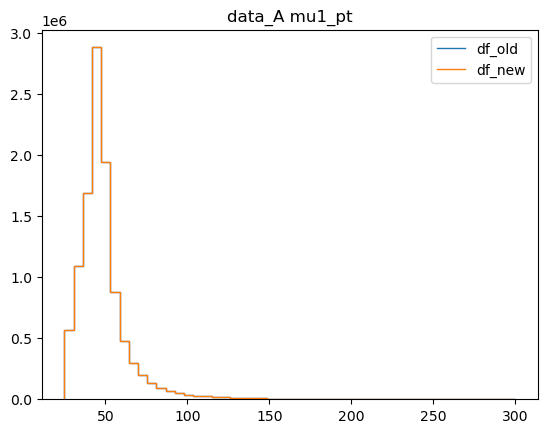

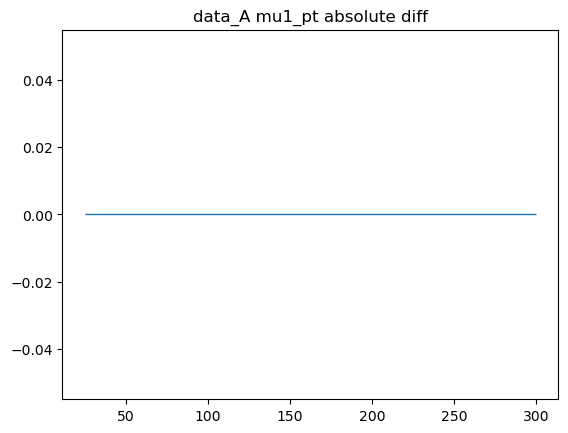

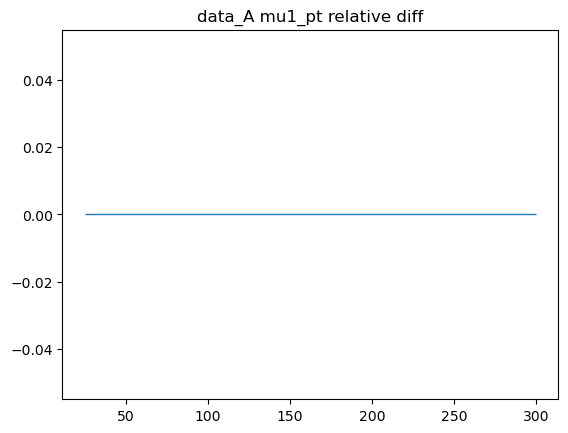

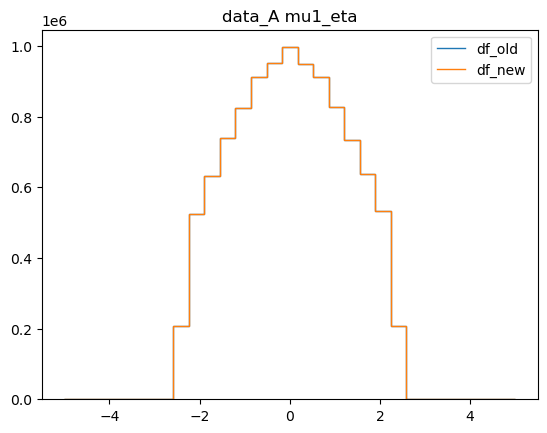

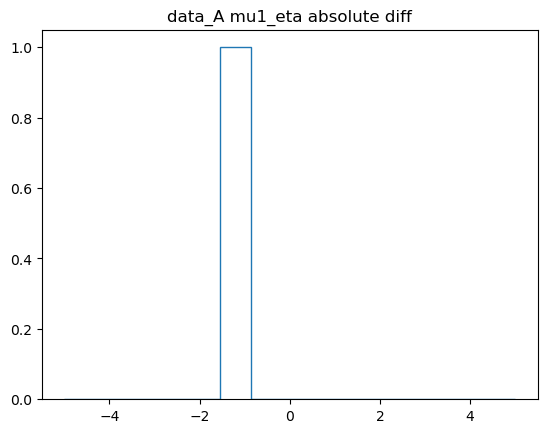

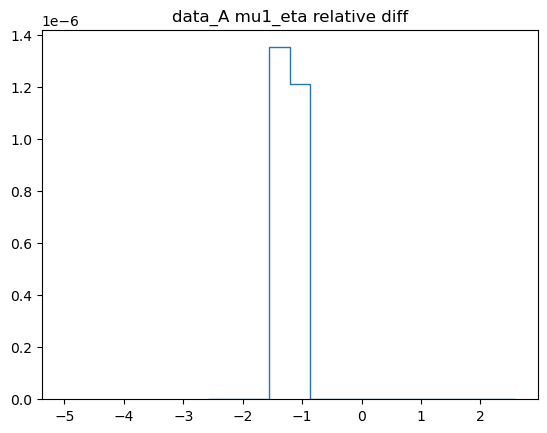

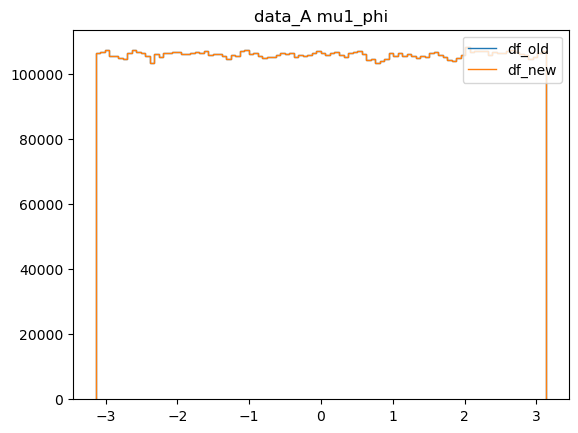

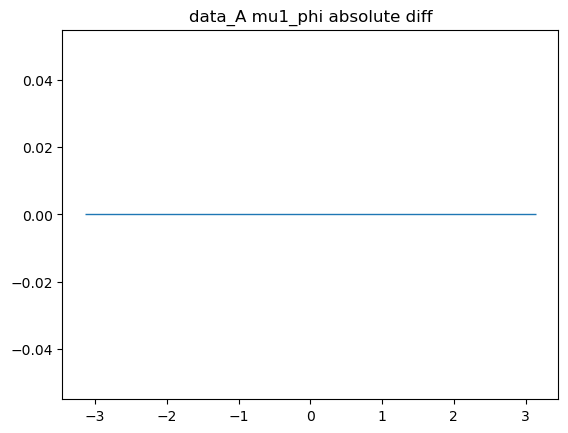

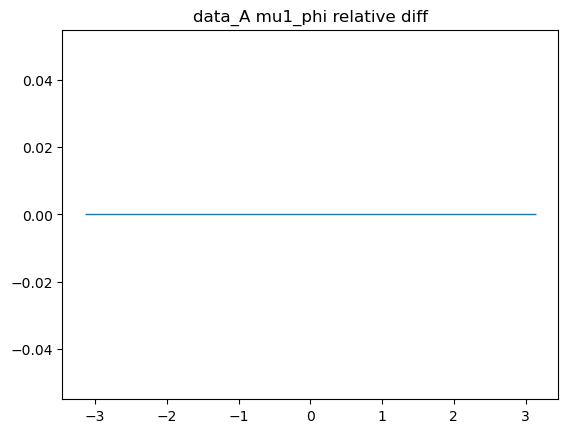

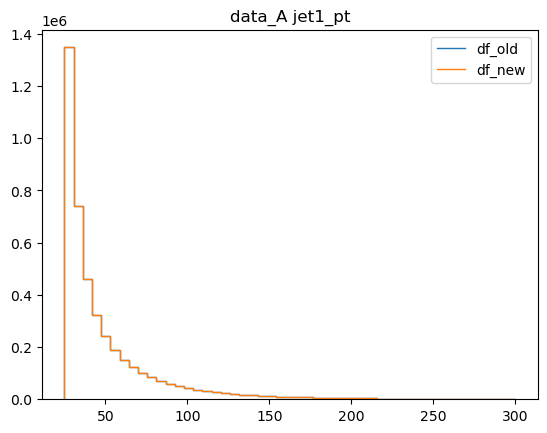

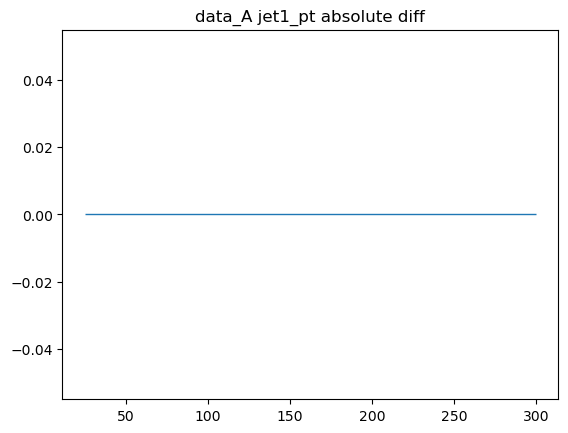

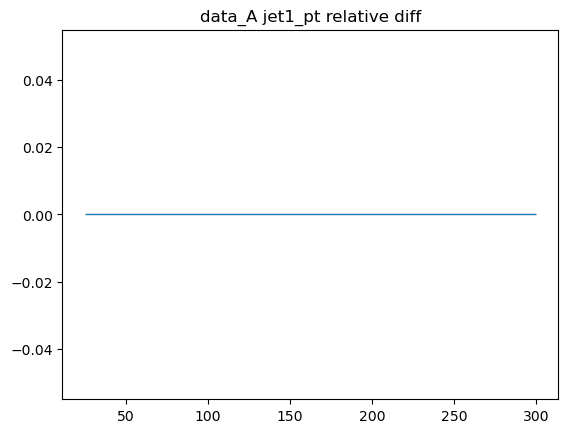

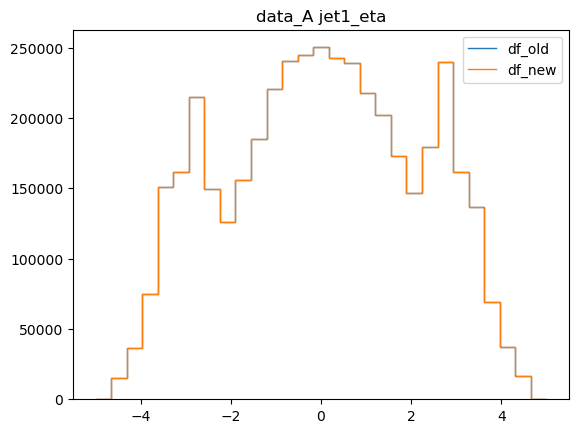

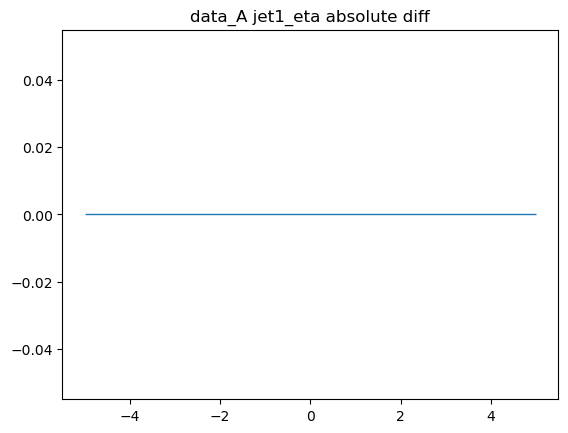

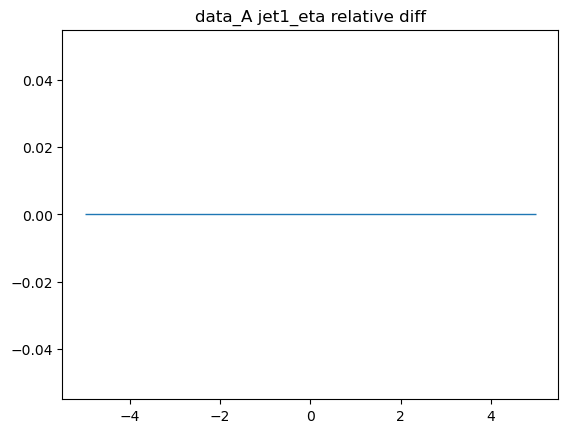

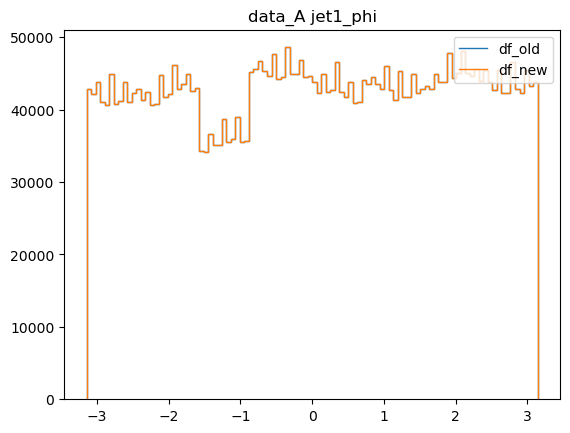

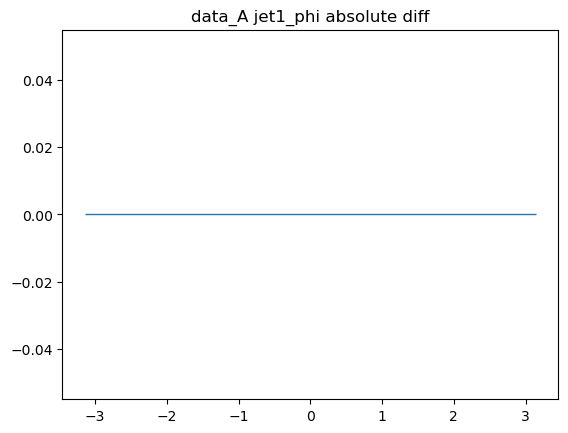

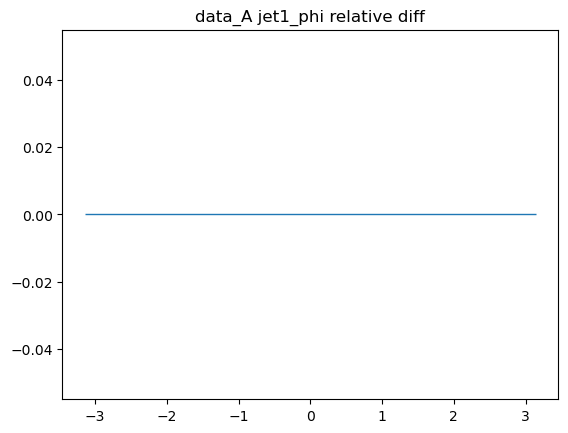

In [15]:
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning ,weights=weights_old)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new)
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(f"{sample} {var}")
    plt.show()
    plt.stairs(abs(hist_new-hist_old), edges)
    plt.title(f"{sample} {var}"+" absolute diff")
    plt.show()
    plt.stairs(abs(hist_new-hist_old)/hist_old, edges)
    plt.title(f"{sample} {var}"+" relative diff")
    plt.show()

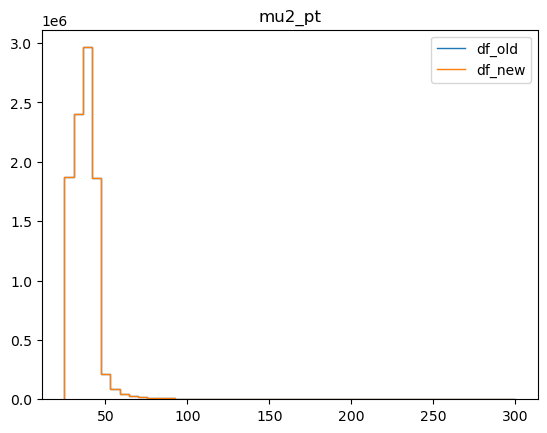

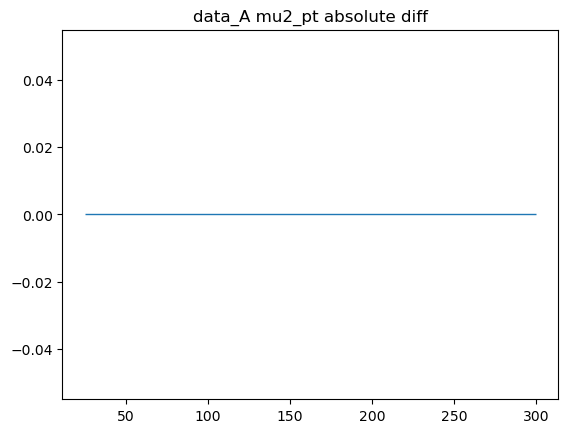

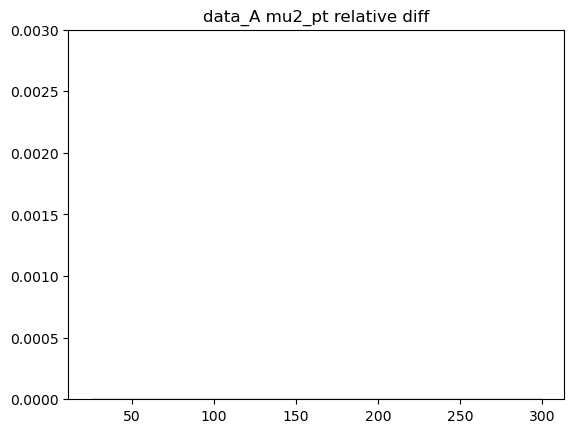

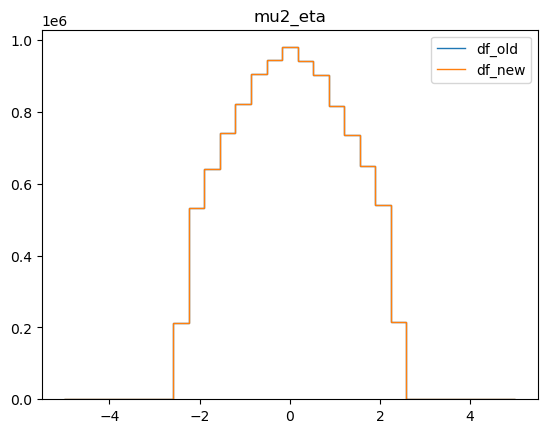

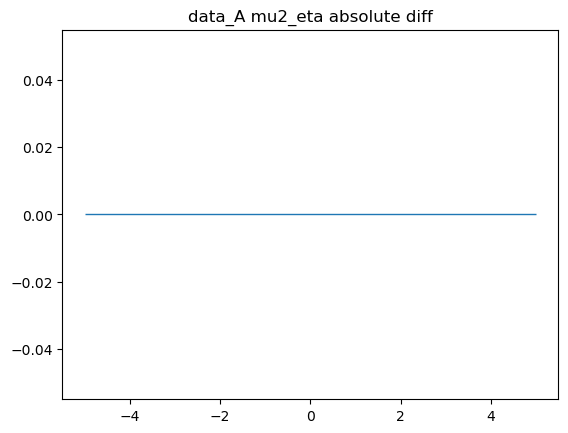

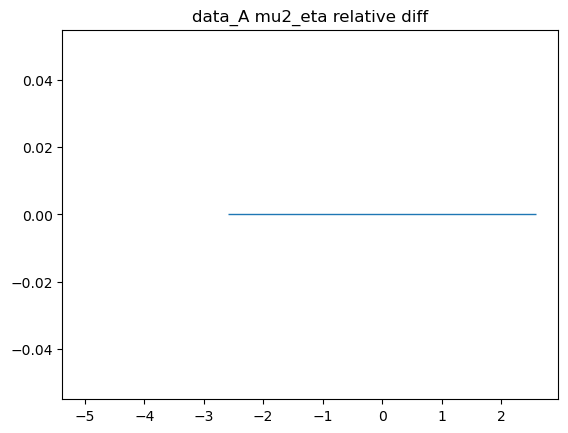

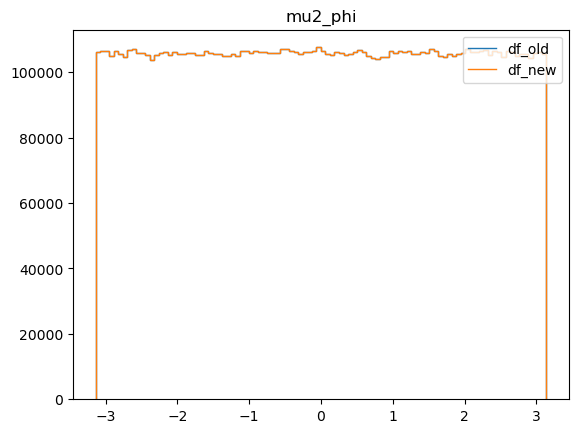

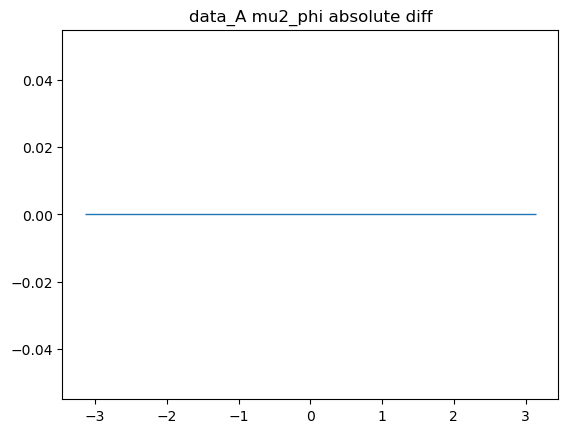

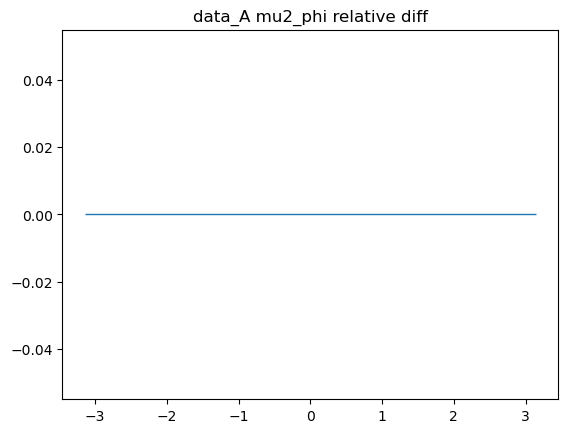

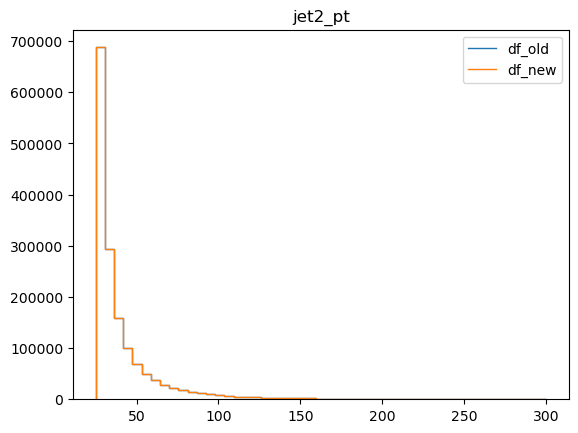

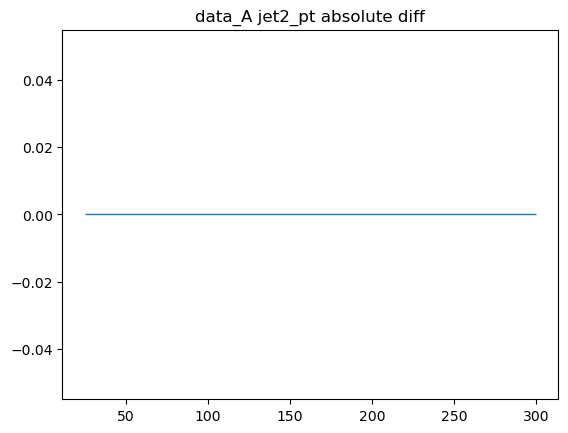

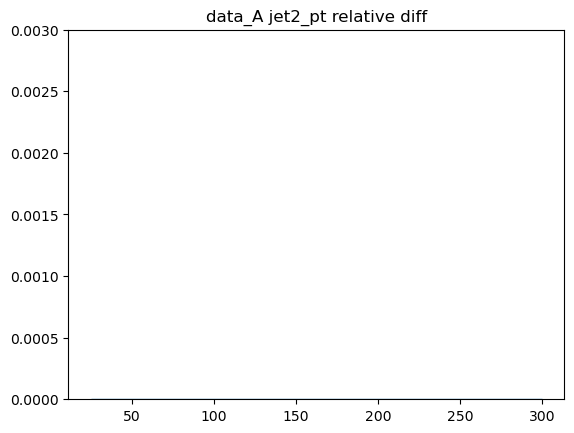

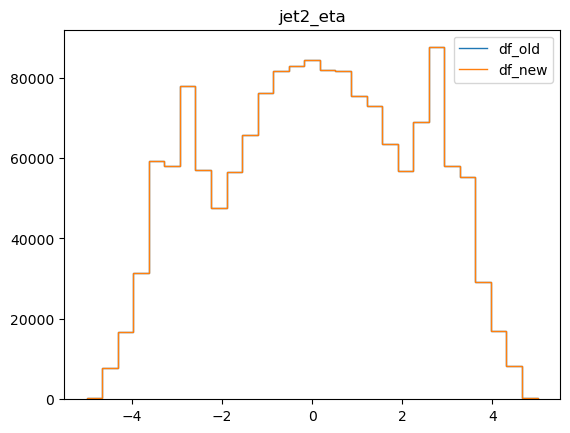

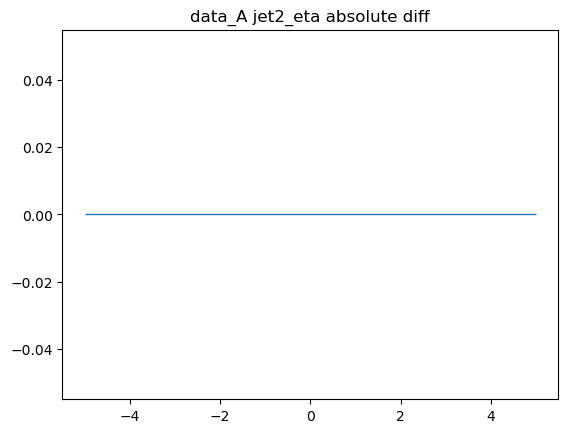

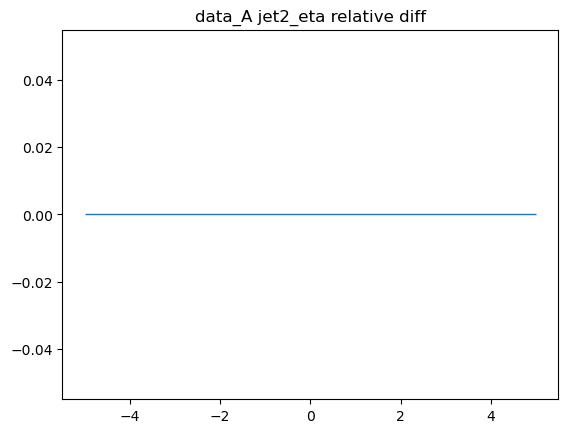

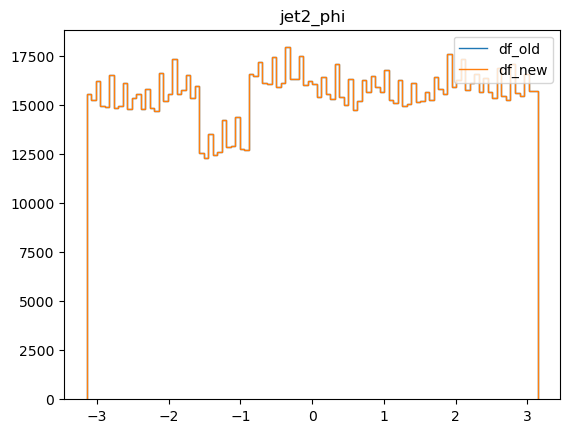

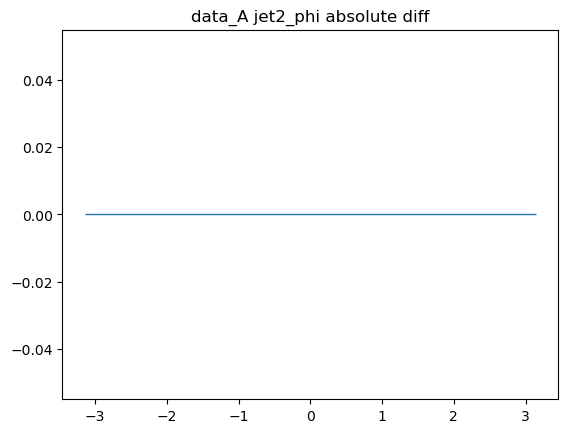

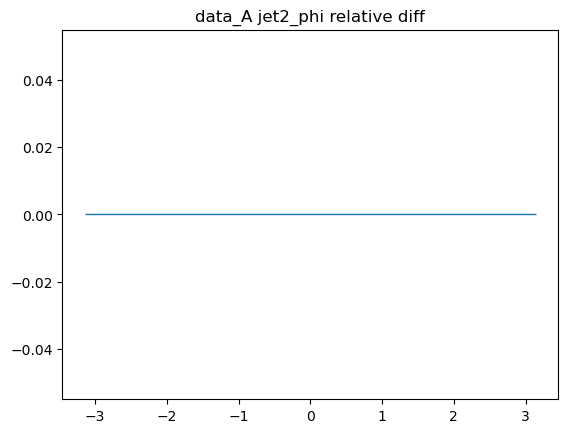

In [9]:
"""
For mu2, special condition is needed bc when there's only one muon, mu2==mu1 in copperhead
"""
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu2_pt","mu2_eta", "mu2_phi", 
             # "jet2_mass", 
             "jet2_pt", "jet2_eta", "jet2_phi"
            ]
    
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # the way copperheadV1 defines mu2 is the muon with the lowest pt, thus the
    # only way to make copperheadV1 and copperheadV2 same is to ensure nmuons ==2
    # if 'mu' in var:
    #     nvars_new = df_new["nmuons"].compute()
    #     nvars_old = df_old["nmuons"].compute()
    # else:
    #     nvars_new = df_new["njets"].compute()
    #     nvars_old = df_old["njets"].compute()
    # hist_old, edges = np.histogram(df_old[nvars_old ==2][var].compute(), bins=binning , weights=weights_old[nvars_old ==2])
    # hist_new, _= np.histogram(df_new[nvars_new ==2][var].compute(), bins=binning , weights=weights_new[nvars_new ==2])
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning , weights=weights_old)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning , weights=weights_new)
    
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs(abs(hist_new-hist_old), edges)
    plt.title(f"{sample} {var}"+" absolute diff")
    plt.show()
    plt.stairs(abs(hist_new-hist_old)/hist_old, edges)
    if "pt" in var:
        plt.ylim(0, 0.003)
    plt.title(f"{sample} {var}"+" relative diff")
    plt.show()

In [19]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
load_path = "/depot/cms/users/yun79/results/stage1/test_full2/f1_0"
# sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
sample = "data_A"
full_load_path_p30 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_2999999975166409/{sample}/*/*.parquet"
full_load_path_p10 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"

df_new_p30 = dak.from_parquet(full_load_path_p30) 
df_new_p10 = dak.from_parquet(full_load_path_p10) 

In [20]:
# !  /depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/data_A

In [21]:
# for i in range(1,27):
#     full_load_path_p30 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/{sample}/{i}/*.parquet"
#     df_new_p30 = dak.from_parquet(full_load_path_p30) 
#     print(i)
#     print(df_new_p30.weights.compute())

In [22]:
weights_new_p30 = ak.to_numpy((df_new_p30["weights"]/df_new_p30["fraction"]).compute())
weights_new_p10 = ak.to_numpy((df_new_p10["weights"]/df_new_p10["fraction"]).compute())
# if "ggh" in sample:
#     print("ggh in sample!")
#     nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/nnlops/wgt.parquet'
#     nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
#     weights_new = weights_new*nnlops_wgts
# print(weights_new_p30)
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]


In [ ]:
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_new_p30, edges = np.histogram(df_new_p30[var].compute(), bins=binning ,weights=weights_new_p30)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new_p10, _= np.histogram(df_new_p10[var].compute(), bins=binning ,weights=weights_new_p10)
    
    plt.stairs(hist_new_p30, edges, label = "p30")
    plt.stairs(hist_new_p10, edges, label = "p10")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new_p30-hist_new_p10), edges)
    plt.title(var+" diff")
    plt.show()

In [ ]:
# sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
sample = "data_A"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_3/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f1_0/{sample}/*/*.parquet"

df_new = dak.from_parquet(full_load_path) 
# region_cut = (df_new.h_peak | df_new.h_sidebands)
# df_new = df_new[region_cut]
#----------------------------------------------------------------------------------
full_load_path = f"/depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/{sample}/*.parquet"
import dask.dataframe as dd
import pandas as pd
# df = dd.from_pandas(pd.DataFrame(), npartitions=1)
df_old = dd.read_parquet(full_load_path)
# region = df_old.region.compute()
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]
weights_old = df_old["weights"].compute()
is_data = "data" in sample
if is_data:
    weights_new = ak.to_numpy((df_new["weights"]/df_new["fraction"]).compute())
else: # MC
    weights_new = ak.to_numpy((df_new["weights"]).compute())
    
if "ggh" in sample:
    print("ggh in sample!")
    nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/{sample}/*/nnlops/*.parquet'
    nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
    weights_new = weights_new*nnlops_wgts

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning ,weights=weights_old)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new)
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(f"{sample} {var}")
    plt.show()
    plt.stairs((hist_new-hist_old)/hist_old, edges)
    plt.title(f"{sample} {var}"+" diff")
    plt.show()

In [ ]:
"""
For mu2, special condition is needed bc when there's only one muon, mu2==mu1 in copperhead
"""
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu2_pt","mu2_eta", "mu2_phi", 
             # "jet2_mass", 
             "jet2_pt", "jet2_eta", "jet2_phi"
            ]
    
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # the way copperheadV1 defines mu2 is the muon with the lowest pt, thus the
    # only way to make copperheadV1 and copperheadV2 same is to ensure nmuons ==2
    # if 'mu' in var:
    #     nvars_new = df_new["nmuons"].compute()
    #     nvars_old = df_old["nmuons"].compute()
    # else:
    #     nvars_new = df_new["njets"].compute()
    #     nvars_old = df_old["njets"].compute()
    # hist_old, edges = np.histogram(df_old[nvars_old ==2][var].compute(), bins=binning , weights=weights_old[nvars_old ==2])
    # hist_new, _= np.histogram(df_new[nvars_new ==2][var].compute(), bins=binning , weights=weights_new[nvars_new ==2])
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning , weights=weights_old)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning , weights=weights_new)
    
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new-hist_old)/hist_old, edges)
    plt.title(var+" diff")
    plt.show()

In [33]:
# ! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/

f0_29999999363555413  f0_29999999908811936  f0_29999999961082674
f0_2999999975166409   f0_29999999916609693  f0_3


In [59]:
# # round(0.29999999961082674, 3)
# ! rm -r /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_29999999961082674/

In [54]:
# start = "/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_29999999961082674/*"
# dest = "/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_3"
# ! mv {start} {dest}

In [60]:
# ! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/*

data_A	data_B	data_C	data_D	dy_M-100To200  ttjets_dl  ttjets_sl


In [18]:
# ! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_2999999975166409/data_A/

0  1  2  3  4  5  6


In [9]:
# import os 
# import glob
# for i in range(7,27):
#     filelist=  glob.glob(f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/data_A/{i}/*.parquet")
#     for file in filelist:
#             os.remove(file)


In [8]:
# filelist

In [80]:
"weights" in df_old.columns

True

In [86]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f1_0/

data_A	dy_M-100To200


In [1]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f1_0/

data_A	data_D		       ggh_powheg     ttjets_dl   ww_2l2nu    wz_3lnu
data_B	dy_M-100To200	       st_tw_antitop  ttjets_sl   wz_1l1nu2q  zz
data_C	ewk_lljj_mll50_mjj120  st_tw_top      vbf_powheg  wz_2l2q
